Classification of Chest X-Ray images using CNN(Convolutional Neural Network)

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import Sequential, layers
from tensorflow.keras.preprocessing.image import load_img
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
image_dir = r'C:\Users\IICET 1\Desktop\Dipali\trainingData'
classes = os.listdir(image_dir)
print(classes)

['COVID', 'NORMAL', 'PNEUMONIA']


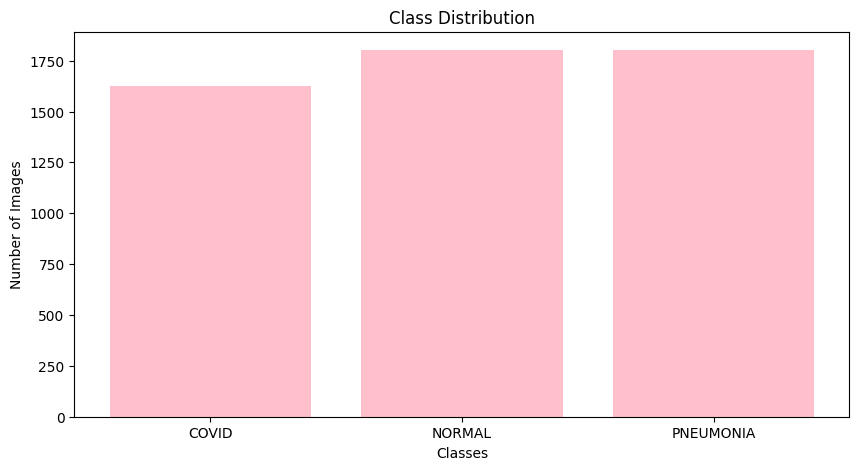

In [3]:
from collections import Counter

# Count images per class
class_counts = Counter()
for cls in classes:
    class_dir = os.path.join(image_dir, cls)
    class_counts[cls] = len(os.listdir(class_dir))

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(),color='pink')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

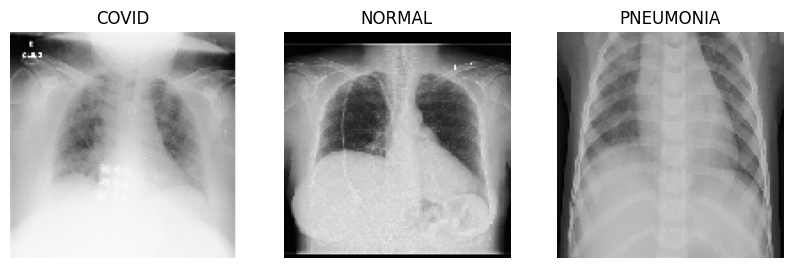

In [4]:
class_dirs = os.listdir(image_dir)
plt.figure(figsize=(10, 10))
for i, cls in enumerate(class_dirs, start=1):
    img_path = os.path.join(image_dir, cls, os.listdir(os.path.join(image_dir, cls))[0])
    img = load_img(img_path, target_size=(128, 128))
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()

In [5]:
# Defining required variables
img_size = 256
batch_size = 32

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    shuffle=True,
    image_size = (img_size,img_size),
    batch_size = batch_size,
    labels='inferred',
    label_mode='int'
)

Found 5228 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
print(class_names)
# Length of batches
len(dataset)

['COVID', 'NORMAL', 'PNEUMONIA']


164

Splitting the tf dataset

In [8]:
# Let's define a function for train val test split
def split_dataset(ds, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True):
    # Get dataset size
    dataset_size = len(ds)

    # Calculate split sizes
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle dataset if required
    if shuffle:
        ds = ds.shuffle(dataset_size)

    # Split dataset
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

In [9]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [10]:
for i in [train_ds, val_ds, test_ds]:
    print(len(i))

131
16
17


Optimize the data pipeline for training machine learning models

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Defining pipeline for resizing, rescaling/normalizing the data and for data augmentation

In [12]:
resize_and_rescale = tf.keras.Sequential([
    # Though already resized, this works for other test data
    tf.keras.layers.Resizing(img_size, img_size), 
    # Normalizing the pixels    
    tf.keras.layers.Rescaling(1.0/255)    
])

Data Augmention

In [13]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    keras.layers.RandomBrightness(0.1),
    keras.layers.RandomContrast(0.1),
])

Building architecture for CNN model

In [14]:
model = Sequential()

# Apply resize_and_rescale and data augmentation
resize_and_rescale,
data_augmentation,

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))

c:\Users\IICET 1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    67,109,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,515,011 (257.55 MB)

 Trainable params: 67,514,115 (257.55 MB)

 Non-trainable params: 896 (3.50 KB)

In [17]:
history = model.fit(train_ds, epochs = 8, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 1062s 8s/step - accuracy: 0.8183 - loss: 2.0398 - val_accuracy: 0.8770 - val_loss: 1.1949
Epoch 2/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 1012s 8s/step - accuracy: 0.9372 - loss: 0.9863 - val_accuracy: 0.9590 - val_loss: 0.7823
Epoch 3/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 1005s 8s/step - accuracy: 0.9602 - loss: 0.8181 - val_accuracy: 0.9727 - val_loss: 0.7340
Epoch 4/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 1014s 8s/step - accuracy: 0.9687 - loss: 0.7215 - val_accuracy: 0.9785 - val_loss: 0.6663
Epoch 5/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 1011s 8s/step - accuracy: 0.9797 - loss: 0.6586 - val_accuracy: 0.9883 - val_loss: 0.5780
Epoch 6/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 1008s 8s/step - accuracy: 0.9830 - loss: 0.5899 - val_accuracy: 0.9863 - val_loss: 0.5633
Epoch 7/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 991s 8s/step - accuracy: 0.9868 - loss: 0.5551 - val_accuracy: 0.9863 - val_loss: 0.5289
Epoch 8/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 1007s 8s/step - accuracy: 0.9809 - loss: 0.5535 - val_accur

Visualization of Training and Validation Loss

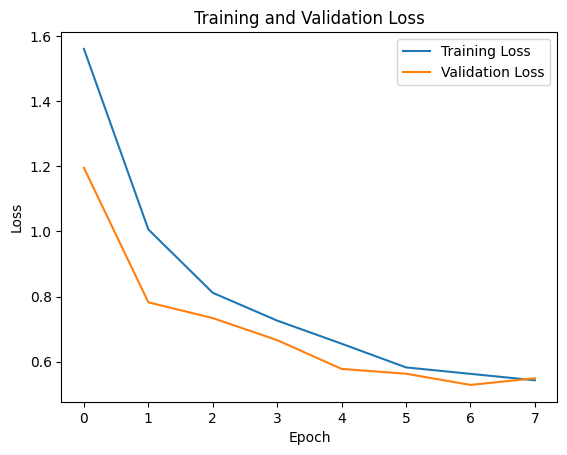

In [18]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Visualization of Training and Validation Accuracy

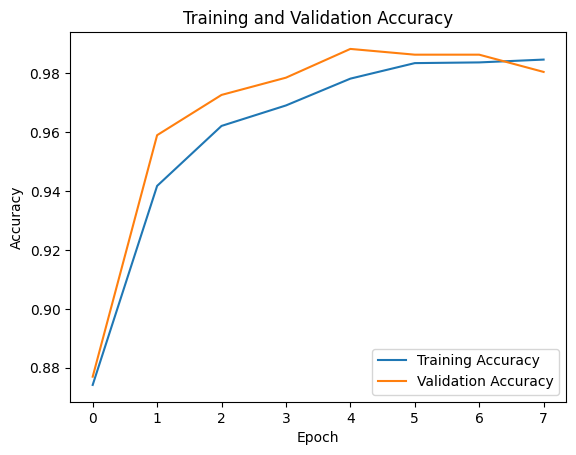

In [19]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
y_pred_probs = model.predict(test_ds)
print(y_pred_probs)

17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 754ms/step
[[8.2632758e-21 5.3494096e-16 1.0000000e+00]
 [1.0000000e+00 2.3477743e-27 1.1993717e-21]
 [1.0000000e+00 9.2964027e-19 2.7869179e-16]
 ...
 [1.0000000e+00 3.5540981e-14 4.6270505e-11]
 [4.7960685e-12 6.8195026e-11 1.0000000e+00]
 [1.0842970e-13 1.1358124e-11 1.0000000e+00]]


In [21]:
# The predicted output is the probability of the image belonging to each separate class,this is due to softmax

In [22]:
y_pred = np.argmax(y_pred_probs, axis=1)   # This returns which column has the highest value
print(y_pred)

[2 0 0 0 1 1 0 1 2 2 0 0 2 1 1 0 2 1 1 2 2 0 2 2 1 0 1 1 1 0 0 2 1 1 0 1 1
 2 0 0 2 1 2 2 1 0 1 1 1 1 1 0 2 0 1 2 0 2 2 1 1 2 1 1 1 1 2 2 0 1 0 1 1 0
 0 0 2 2 0 0 1 1 2 2 2 2 2 1 2 0 2 0 1 0 2 2 0 0 0 1 1 1 2 1 1 0 1 0 0 1 2
 2 1 0 0 2 1 1 1 0 0 0 2 0 2 0 2 0 2 0 1 2 0 2 2 2 2 1 1 2 2 0 0 0 1 1 0 0
 1 1 0 0 1 2 0 2 1 2 2 0 0 1 2 2 2 1 1 2 0 0 2 2 2 0 0 2 1 2 0 1 1 0 1 0 0
 1 0 2 0 0 1 1 2 2 1 0 0 2 0 1 1 1 0 2 1 1 2 1 2 1 2 1 2 0 0 2 2 2 2 1 1 0
 2 2 0 1 1 1 0 2 2 1 0 2 2 1 2 1 0 0 0 1 1 1 2 1 1 2 2 2 1 1 1 0 0 1 2 0 1
 2 0 2 2 0 1 0 1 0 2 2 1 2 2 2 1 1 2 0 2 0 2 2 2 0 0 0 1 1 0 2 2 1 1 1 1 2
 1 1 0 2 0 2 2 2 0 1 1 0 1 0 2 0 0 0 1 2 2 0 1 1 2 1 0 2 2 1 0 1 1 0 2 0 2
 0 2 0 1 1 0 2 0 1 0 0 0 2 1 2 2 0 2 1 0 2 2 1 2 2 1 1 0 1 1 2 0 1 0 2 2 0
 2 1 2 0 0 2 2 0 2 2 1 1 0 2 0 1 1 2 0 1 2 2 2 0 2 2 2 2 0 0 2 1 1 2 2 0 2
 0 0 1 0 1 0 0 1 1 2 1 0 2 2 0 0 0 2 1 2 2 2 1 1 2 0 0 1 0 1 0 0 2 1 2 2 0
 2 1 1 2 1 1 0 1 0 2 0 1 1 0 2 0 1 0 2 0 2 2 1 0 1 2 2 0 2 1 1 0 2 0 0 1 1
 1 0 0 1 0 1 2 0 1 1 0 1 

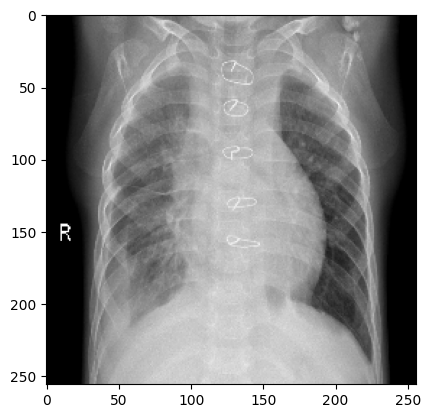

In [23]:
for images_batch, labels_batch in test_ds.take(1):
    plt.imshow((images_batch[0].numpy().astype('uint8')))
# for print(images_batch[0]) , we can see this is a tensor, we convert this to numpy array before plotting image
# Instead of plt.imshow, if we print this, we will see it as a 3 dimesional array RGB

First image to predict
First images actual label:  PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
Predicted label:  PNEUMONIA


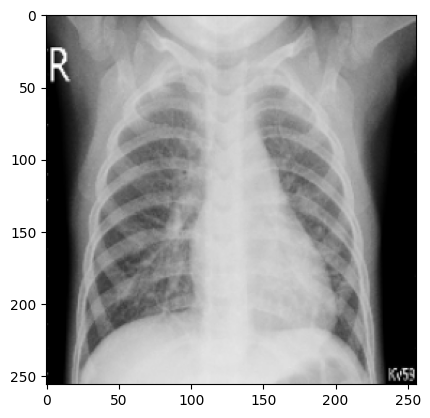

In [24]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')  # [0] gives the first image of the batch 1, 2, 3, for 2nd, 3rd ....
    first_label = labels_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print('First images actual label: ', class_names[first_label]) #class_names gives the names instead of 0,1 or 2
    batch_prediction = model.predict(images_batch)   # This is the prediction of all 32 images of the first batch
    print('Predicted label: ' , class_names[np.argmax(batch_prediction[0])])   # this is the prediction of the first image
    
    # Each time we run this, we'll get a new image due to shuffle in ds.take()

Showing prediction confidence

In [25]:
# We do this to predict the model on a random image(beyond the dataset, now we're defining a function
def predict(model, img): # A function which takes model and image as input
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())   # convert image into image array
    img_array = tf.expand_dims(img_array, 0)    # create a batch out of it

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


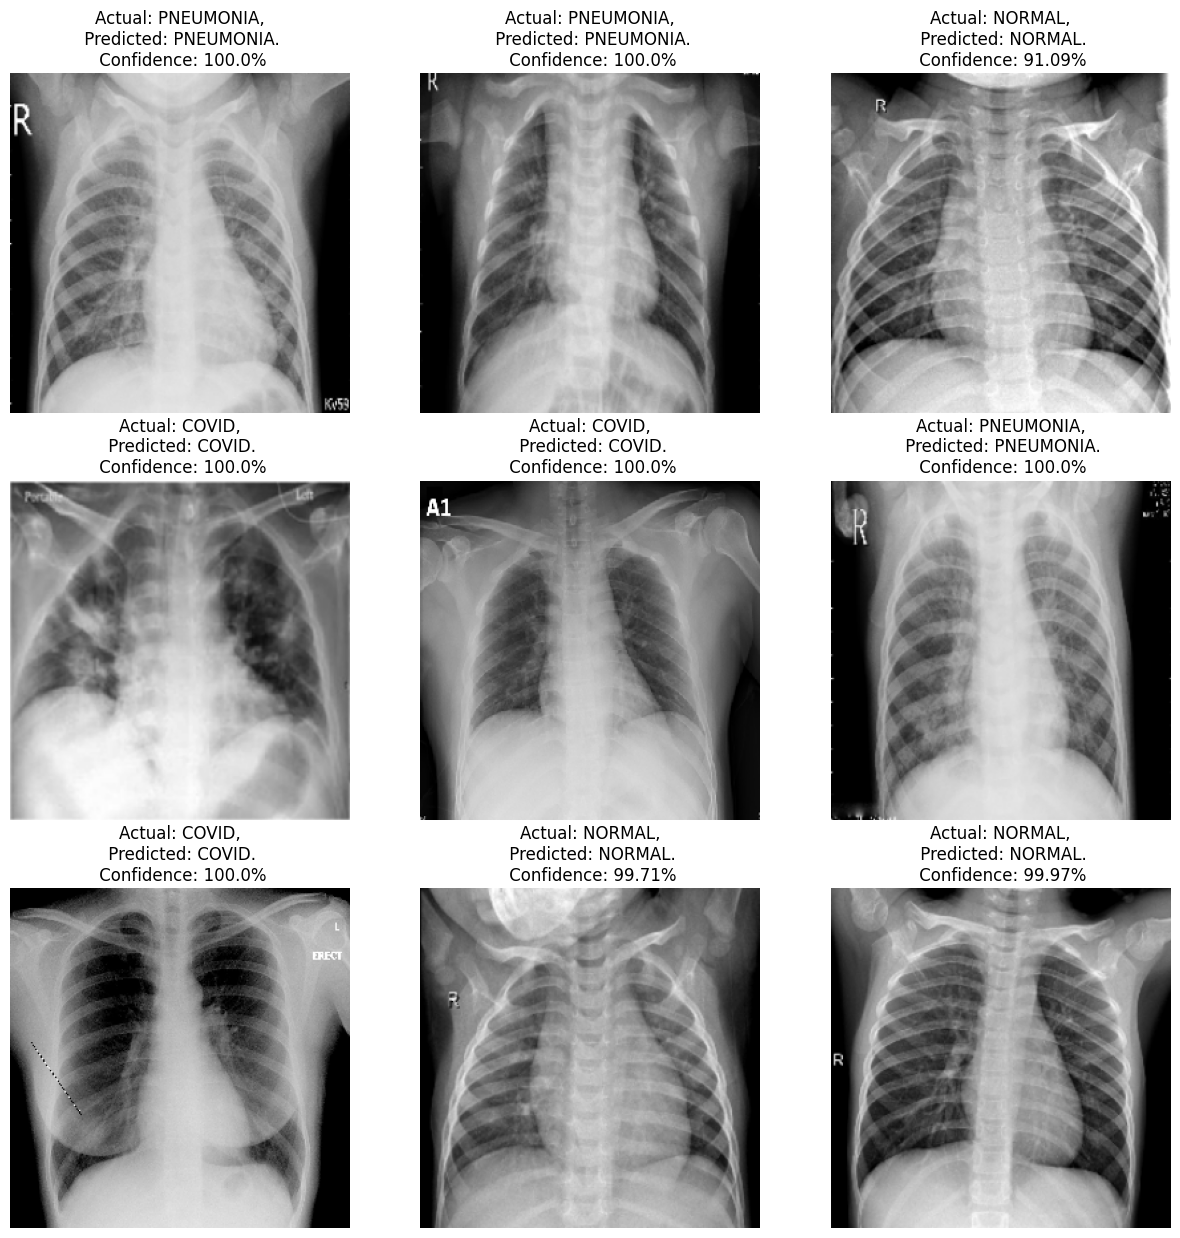

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2):
    for i in range(9):     # picking first 9 images from the batch
        ax = plt.subplot(3, 3, i + 1)  # subplot to show all the images
        plt.imshow(images[i].numpy().astype("uint8"))   # Show the image
        
        predicted_class, confidence = predict(model, images[i].numpy())  # Using above defined function
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")  # Turn off the grid